In [11]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
train_path = 'train'
valid_path = 'valid'
test_path = 'test'

In [13]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=['cat', 'dog','panda'], batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['cat', 'dog','panda'], batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=['cat', 'dog','panda'], batch_size=10, shuffle=False)

Found 2550 images belonging to 3 classes.
Found 300 images belonging to 3 classes.
Found 150 images belonging to 3 classes.


In [14]:
mobile = tf.keras.applications.mobilenet.MobileNet()

In [15]:
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

In [21]:
x = mobile.layers[-6].output
output = Dense(units=3, activation='softmax')(x)
model = Model(inputs=mobile.input, outputs=output)

In [22]:
for layer in model.layers[:-5]:
    layer.trainable = False

In [23]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
model.fit(x=train_batches,
          steps_per_epoch=len(train_batches),
          validation_data=valid_batches,
          validation_steps=len(valid_batches),
          epochs=10,
          verbose=2
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 255 steps, validate for 30 steps
Epoch 1/10
255/255 - 216s - loss: 0.2511 - accuracy: 0.9078 - val_loss: 1.4689 - val_accuracy: 0.5100
Epoch 2/10
255/255 - 214s - loss: 0.0606 - accuracy: 0.9855 - val_loss: 0.7673 - val_accuracy: 0.6733
Epoch 3/10
255/255 - 210s - loss: 0.0260 - accuracy: 0.9996 - val_loss: 0.9873 - val_accuracy: 0.6433
Epoch 4/10
255/255 - 203s - loss: 0.0144 - accuracy: 1.0000 - val_loss: 1.1312 - val_accuracy: 0.6300
Epoch 5/10
255/255 - 207s - loss: 0.0096 - accuracy: 1.0000 - val_loss: 1.1033 - val_accuracy: 0.6400
Epoch 6/10
255/255 - 208s - loss: 0.0069 - accuracy: 1.0000 - val_loss: 1.1392 - val_accuracy: 0.6533
Epoch 7/10
255/255 - 208s - loss: 0.0052 - accuracy: 1.0000 - val_loss: 1.1850 - val_accuracy: 0.6533
Epoch 8/10
255/255 - 209s - loss: 0.0041 - accuracy: 1.0000 - val_loss: 1.1748 - val_accuracy: 0.6533
Epoch 9/10
255/255 - 209s - loss: 0.0032 - accuracy: 1.0000 - val_loss: 1.2224 - val_accura

In [29]:
test_labels=test_batches.classes

In [30]:
predictions = model.predict(x=test_batches, verbose=0)

In [31]:
def plot_confusion_matrix(cm, classes,
        normalize=False,
        title='Confusion matrix',
        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [32]:
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))

In [33]:
cm_plot_labels = ['cat','dog','pandas']

Confusion matrix, without normalization
[[44  0  6]
 [30  7 13]
 [ 6  0 44]]


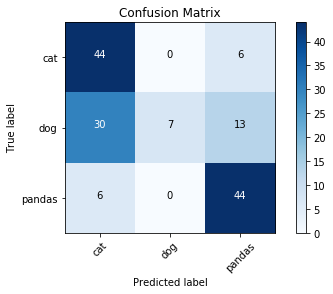

In [34]:
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [35]:
json_string = model.to_json()
json_string

'{"class_name": "Model", "config": {"name": "model_1", "layers": [{"class_name": "InputLayer", "config": {"batch_input_shape": [null, 224, 224, 3], "dtype": "float32", "sparse": false, "ragged": false, "name": "input_2"}, "name": "input_2", "inbound_nodes": []}, {"class_name": "ZeroPadding2D", "config": {"name": "conv1_pad", "trainable": false, "dtype": "float32", "padding": [[0, 1], [0, 1]], "data_format": "channels_last"}, "name": "conv1_pad", "inbound_nodes": [[["input_2", 0, 0, {}]]]}, {"class_name": "Conv2D", "config": {"name": "conv1", "trainable": false, "dtype": "float32", "filters": 32, "kernel_size": [3, 3], "strides": [2, 2], "padding": "valid", "data_format": "channels_last", "dilation_rate": [1, 1], "activation": "linear", "use_bias": false, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_con

In [38]:
model.save_weights('cat_dog_pandas_weights.h5')

In [39]:
model.save('cat_dog_pandas_model.h5')

In [40]:
from tensorflow.keras.models import load_model
new_model = load_model('cat_dog_pandas_model.h5')

In [41]:
new_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128 

In [44]:
def prepare_image(file):
    img_path = 'test'
    img = image.load_img(img_path + file, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return tf.keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

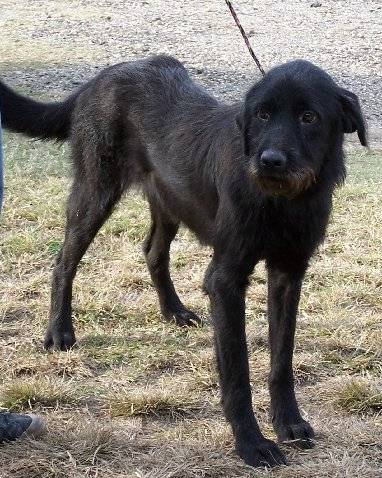

In [46]:
from IPython.display import Image
Image(filename='test/1.jpg', width=300,height=200) 

In [51]:
preprocessed_image = prepare_image('/1.jpg')
predictions = new_model.predict(preprocessed_image)

In [55]:
predictions

array([[3.4453511e-05, 9.9996495e-01, 6.4901803e-07]], dtype=float32)